# 多腕バンディット問題

## 必要なモジュールをimport

In [3]:
import numpy as np
import matplotlib.pyplot as plt

## Banditクラスを定義

確率 $ rate_i $ で当たる台を指定された数持つ

In [ ]:
class Bandit:
    def __init__(self, n_arms):
        self.n_arms = n_arms
        self.rates = np.random.rand(n_arms) # ランダムに確率を生成
        
    def pull(self, arm):
        # Simulate pulling an arm
        if arm < 0 or arm >= self.n_arms:
            raise ValueError("Invalid arm index")
        return np.random.rand() < self.rates[arm] # 成功確率に基づいて成功/失敗を返す

## Agent

### 期待値の計算
ある行動を$n$回試行して推定される期待値$Q_n$は以下の式で表される。なお、$R_i$は$i$回目の試行で得た報酬である。

$$
Q_n = \frac 1 n (R_1 + R_2 + ... + R_n) \tag{1}
$$

同様に、$n-1$回試行して推定される期待値$Q_{n-1}$は以下の式で表される。

$$
Q_{n-1} = \frac 1 {n-1} (R_1 + R_2 + ... + R_{n-1}) \tag{2}
$$

変形して

$$
(n-1) Q_{n-1} = R_1 + R_2 + ... + R_{n-1} \tag{3}
$$

式(3)を式(1)に代入することで$Q_n$は以下のように表現できる。

$$
Q_n = \frac 1 n \{(n-1) Q_{n-1} + R_n\} \\
= (1 - \frac 1 n) Q_{n-1} + \frac 1 n R_n \\
= Q_{n-1} + \frac 1 n (R_n - Q_{n-1}) \tag{4}
$$

これにより、$n-1$回目の試行で得た$Q_{n-1}$と$n$回目の試行で得た$R_n$のみから$Q_n$を求めることができる。

### ε-greedy法
基本的なアルゴリズム。

$n$回目の試行において、確率$\varepsilon$でランダムな行動をとり(探索)、それ以外は最も$Q_n$の高い行動をとる(活用)。

In [ ]:
class Agent:
    def __init__(self, n_arms, epsilon):
        self.n_arms = n_arms
        self.epsilon = epsilon
        self.q_values = np.zeros(n_arms) # 各行動のQ値
        self.action_counts = np.zeros(n_arms) # 各行動の試行回数

    def select_action(self):
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.n_arms) # 探索: ランダムに行動を選択
        else:
            return np.argmax(self.q_values) # 活用: Q値が最大の行動を選択
        
    def update(self, arm, reward):
        self.action_counts[arm] += 1
        # Q値の更新
        self.q_values[arm] += (reward - self.q_values[arm]) / self.action_counts[arm]

## 実行する
1シミュレーション内の総試行回数は1000回、$\varepsilon$を0.01, 0.1, 0.3と変化させてそれぞれ100回シミュレーションを行う。

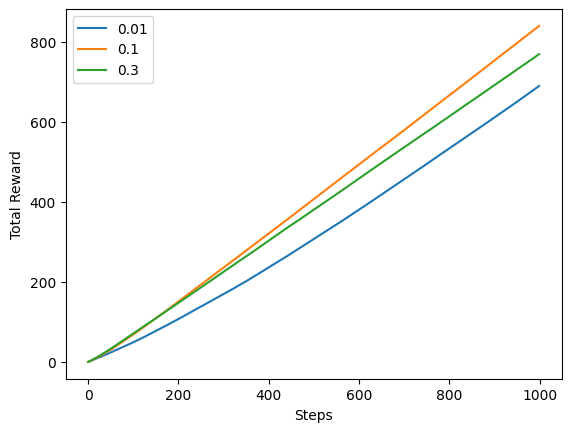

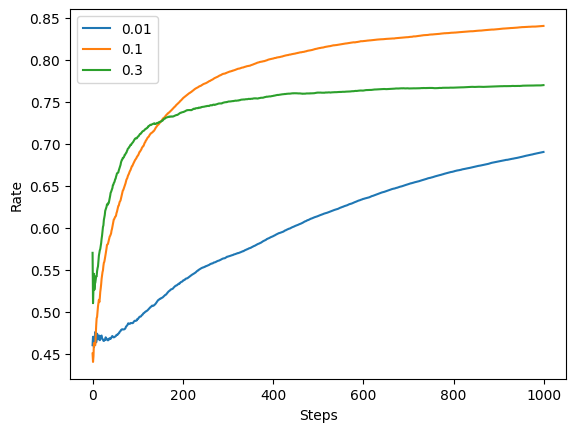

In [6]:
np.random.seed(42) # シード値を固定

EPSILONS = [0.01, 0.1, 0.3]
N_ARM = 10
EPISODES = 100
STEPS = 1000

reward_history = []
rate_history = []

for epsilon in EPSILONS: # 各epsilonでエピソードを実行
    epsilon_reward_history = []
    epsilon_rate_history = []
    for episode in range(EPISODES):
        bandit = Bandit(N_ARM)
        agent = Agent(N_ARM, epsilon)
        total_reward = 0
        total_rewards = []
        rates = []
        for step in range(STEPS):
            arm = agent.select_action()
            reward = bandit.pull(arm)
            agent.update(arm, reward)
            total_reward += reward
            total_rewards.append(total_reward)
            rates.append(total_reward / (step + 1))            
        epsilon_reward_history.append(total_rewards)
        epsilon_rate_history.append(rates)
    reward_history.append(np.mean(epsilon_reward_history, axis=0))
    rate_history.append(np.mean(epsilon_rate_history, axis=0))
    
# 結果を表示
plt.ylabel('Total Reward')
plt.xlabel('Steps')
plt.plot(np.array(reward_history).T)
plt.legend(EPSILONS)
plt.show()

plt.ylabel('Rate')
plt.xlabel('Steps')
plt.plot(np.array(rate_history).T)
plt.legend(EPSILONS)
plt.show()

## 考察ポイント
グラフを見ると、$\varepsilon=0.1$のときの最終的な報酬と勝率が最も高いことがわかる。

$\varepsilon=0.01$のときは勝率の上昇が緩やかになっている。探索頻度が低いため、正確な期待値の推定に時間がかかっていると考えられる。step数を増やすことで$\varepsilon=0.1$のときよりも高い勝率に収束する可能性がある。

また、$\varepsilon=0.3$のときは早い段階で勝率が高くなっているものの、最終的な勝率は$\varepsilon=0.1$のときに比べて低い値に収束している。探索頻度が高いため、期待値の高い台を選びにくくなっていると考えられる。

総じて、ε-greedy法では$\varepsilon$の値が低すぎても高すぎでもいけないことがわかる。

## 非定常問題

ここまで考えてきたのは、環境が変化しない**定常問題**であった。これに対し、環境が変化するような問題を**非定常問題**という。

定常状態で用いてきた以下の式は$n$回得た報酬$R_i$の平均を取っているため重みは$\frac 1 n$で全て同じになっている。

$$
Q_n = Q_{n-1} + \frac 1 n (R_n - Q_{n-1})
$$

環境が変化する非定常問題では、過去の報酬ほど情報としての重要性が低くなる。

そこで、固定値$\alpha (0 \le \alpha \le 1)$を用いて以下の式を使うように変更することを考える。

$$
Q_n = Q_{n-1} + \alpha (R_n - Q_{n-1})
$$

この式を展開すると以下のようになる。

$$
Q_n = \alpha R_n + \alpha (1 - \alpha) R_{n - 1} + ... + \alpha (1 - \alpha)^{n-1} R_1 + (1 - \alpha)^n Q_0
$$

各報酬に対する重みを見ると、$\alpha, \alpha (1 - \alpha), ..., \alpha (1 - \alpha)^{n-1}$と、指数関数的に減少していることがわかる。

以下で実際に非定常問題を解いてみる。

In [7]:
# 非定常バンディット
class NonStationaryBandit(Bandit):
    def pull(self, arm):
        ret = super().pull(arm)
        # 確率が更新される
        self.rates += 0.1 * np.random.randn(self.n_arms)
        return ret
    
# alphaの値を使ってQ値を更新するエージェント
class AlphaAgent(Agent):
    def __init__(self, n_arms, alpha, epsilon):
        super().__init__(n_arms, epsilon)
        self.alpha = alpha

    def update(self, arm, reward):
        self.action_counts[arm] += 1
        # alphaを使ってQ値を更新
        self.q_values[arm] += self.alpha * (reward - self.q_values[arm])

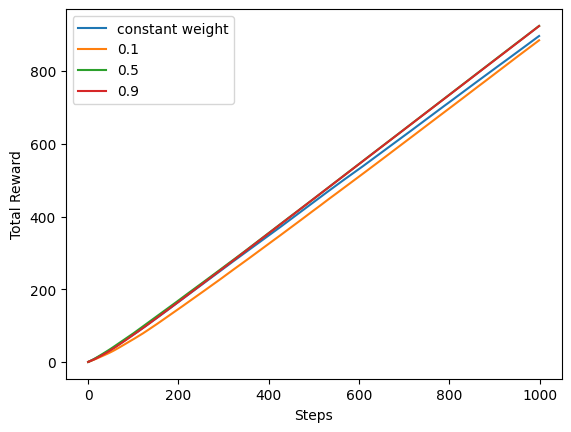

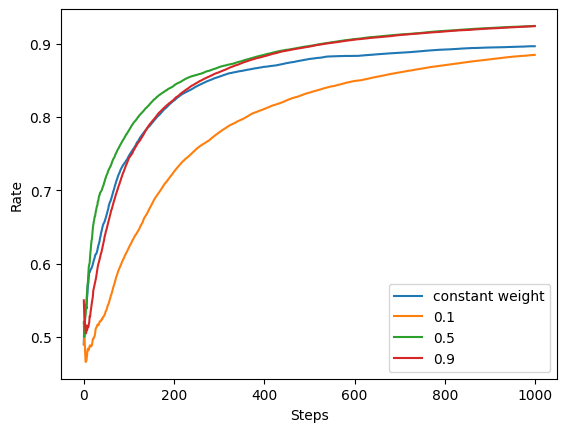

In [15]:
np.random.seed(42) # シード値を固定

ALPHAS = [0.1, 0.5, 0.9]
EPSILON = 0.1
EPISODES = 100
STEPS = 1000

reward_history = []
rate_history = []

# 定常問題と同じAgentで実行
alpha_reward_history = []
alpha_rate_history = []
for episode in range(EPISODES):
    bandit = NonStationaryBandit(N_ARM)
    agent = Agent(N_ARM, EPSILON)
    total_reward = 0
    total_rewards = []
    rates = []
    for step in range(STEPS):
        arm = agent.select_action()
        reward = bandit.pull(arm)
        agent.update(arm, reward)
        total_reward += reward
        total_rewards.append(total_reward)
        rates.append(total_reward / (step + 1))
    alpha_reward_history.append(total_rewards)
    alpha_rate_history.append(rates)
reward_history.append(np.mean(alpha_reward_history, axis=0))
rate_history.append(np.mean(alpha_rate_history, axis=0))

for alpha in ALPHAS: # 各alphaでエピソードを実行
    alpha_reward_history = []
    alpha_rate_history = []
    for episode in range(EPISODES):
        bandit = NonStationaryBandit(N_ARM)
        agent = AlphaAgent(N_ARM, alpha, EPSILON)
        total_reward = 0
        total_rewards = []
        rates = []
        for step in range(STEPS):
            arm = agent.select_action()
            reward = bandit.pull(arm)
            agent.update(arm, reward)
            total_reward += reward
            total_rewards.append(total_reward)
            rates.append(total_reward / (step + 1))            
        alpha_reward_history.append(total_rewards)
        alpha_rate_history.append(rates)
    reward_history.append(np.mean(alpha_reward_history, axis=0))
    rate_history.append(np.mean(alpha_rate_history, axis=0))
    
# 結果を表示
plt.ylabel('Total Reward')
plt.xlabel('Steps')
plt.plot(np.array(reward_history).T)
plt.legend(["constant weight"] + ALPHAS)
plt.show()

plt.ylabel('Rate')
plt.xlabel('Steps')
plt.plot(np.array(rate_history).T)
plt.legend(["constant weight"] + ALPHAS)
plt.show()

## 考察ポイント
重みが一定なAgentに比べ、$\alpha$の値が0.5や0.9のエージェントのほうが報酬と勝率が高くなっていることがわかる。

このことから、最近の報酬を重視することで最適化できると考えられる。

$\alpha=0.1$のときは報酬と勝率がともに低い値となっているが、$\alpha$の値が小さいほど過去の報酬の重みは大きくなるため、必要のない情報を考慮しすぎている可能性が考えられる。